In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats
from matplotlib.collections import LineCollection

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages, get_voltage_histograms
import isi_indexing as ii
from readout import load_results
import spatial

import conf.isi5_mouse as cfg
from demonstrator import demonstrator

import styling

In [2]:
labelling = {
    'nspikes': 'Response size',
    'pspike': 'Spike probability',
    'Activity': '$V_{static}$ (mV)',
    'Depression': '$V_{STD}$ (mV)',
    'Threshold': '$V_{TA}$ (mV)',
    'Synapses': '$V_{syn}$ (mV)',
    'Reset': '$V_{reset}$ (mV)',
    'v': 'Membrane potential v (mV)',
    'u': 'Undepressed potential u (mV)',
    'th_adapt': 'Threshold (mV)',
    'vsyn': '$v_{syn}$',
    'Vall': '$\\Sigma V$ (mV)'
}
depressive_measures = ('Depression', 'Threshold')
voltage_measures = depressive_measures + ('Synapses', 'Reset')
raw_measures = 'th_adapt', 'u', 'v', 'vsyn'
pu.colors.update({'Activity': 'cyan', 'Vall': 'k',
                  'th_adapt': pu.colors['Threshold'], 'u': pu.colors['Depression'], 'v': 'b', 'vsyn':'magenta'})
conds = ('std', 'msc', 'dev')
nonstandard = ('msc', 'dev')

In [3]:
net, ipair, istim = [demonstrator[k] for k in ('net', 'ipair', 'istim')]
pair, stim, Bstim = cfg.pairings[ipair], cfg.pairings[ipair][istim], cfg.pairings[ipair][1-istim]

In [4]:
netf = dd.io.load(cfg.netfile.format(net=net))
X, Y = netf['X']/cfg.params['r_dish'].item(), netf['Y']/cfg.params['r_dish'].item()
W = netf['W']
Xstim, Ystim = spatial.create_stimulus_locations(cfg.params)
Xstim = Xstim / cfg.params['r_dish']
Ystim = Ystim / cfg.params['r_dish']

In [5]:
def scatter_values(ax, **kwargs):
    m = ax.scatter(X, Y, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_aspect('equal')
    return m

In [6]:
ms = 20

# TA only

In [7]:
isi, STD, TA, templ = 500, 0, 1, 'R'
res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ), {'u': 'v'})
half = {}

In [8]:
episodes = {cond: res['pairs'][ipair][cond][stim] for cond in conds}
sequences = {cond: res['sequences'][episode] for cond, episode in episodes.items()}
trials = {cond: seq == cfg.stimuli[stim] for cond, seq in sequences.items()}
trials.update({f'{cond}-nontarget': seq != cfg.stimuli[stim] for cond, seq in sequences.items()})
trials.update({f'{cond}-B': seq == cfg.stimuli[cfg.pairings[ipair][1-istim]] for cond, seq in sequences.items()})

In [9]:
half["bspikes"] = {}
for cond in conds:
    half["bspikes"][cond] = np.zeros((cfg.params['N'], len(sequences[cond]), res['raw_dynamics']['v'].shape[-1]), bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episodes[cond]][k] for k in ('pulsed_i', 'pulsed_t')])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        half["bspikes"][cond][i, itrial, t] = True
    assert np.all(half["bspikes"][cond].sum(2) == res['raw_spikes'][episodes[cond]]['pulsed_nspikes'].T)

In [10]:
half["TA_A_dev"] = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev'], 0].mean(1)*volt/mV
half["TA_A_msc"] = res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc'], 0].mean(1)*volt/mV
half["dTA_A"] = half["TA_A_dev"] - half["TA_A_msc"]
half["XA_dev"] = half["bspikes"]['dev'][:, trials['dev']].sum(2).mean(1)
half["XA_msc"] = half["bspikes"]['msc'][:, trials['msc']].sum(2).mean(1)
half["dXA"] = half["XA_dev"] - half["XA_msc"]
half["TA_B_dev"] = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev-B'], 0].mean(1)*volt/mV
half["TA_B_msc"] = res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc-B'], 0].mean(1)*volt/mV
half["dTA_B"] = half["TA_B_dev"] - half["TA_B_msc"]
half["XB_dev"] = half['XnotA_dev'] = half["bspikes"]['dev'][:, trials['dev-B']].sum(2).mean(1)
half["XB_msc"] = half["bspikes"]['msc'][:, trials['msc-B']].sum(2).mean(1)
half["XnotA_msc"] = half["bspikes"]['msc'][:, ~trials['msc']].sum(2).mean(1)
half["XnotAB_msc"] = half["bspikes"]['msc'][:, ~(trials['msc']|trials['msc-B'])].sum(2).mean(1)
half["dXnotA"] = half["XB_dev"] - half["XnotA_msc"]
half["dXB_adaptation"] = half["XB_dev"] - half["XB_msc"]
half["dXB_stimchange"] = half["XB_msc"] - half["XnotAB_msc"]

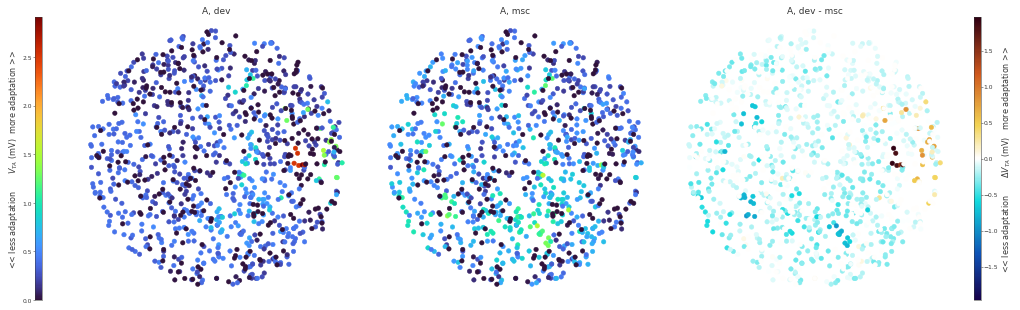

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs([half["TA_A_dev"], half["TA_A_msc"]]).max()
m = scatter_values(axs[0], c=half["TA_A_dev"], s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[0].set_title('A, dev')
m = scatter_values(axs[1], c=half["TA_A_msc"], s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[1].set_title('A, msc')
plt.colorbar(m, ax=axs, label='<< less adaptation\t $V_{TA}$ (mV) \tmore adaptation >>', location='left', aspect=40, pad=0.02)

vmax = np.abs(half["dTA_A"]).max()
m = scatter_values(axs[2], c=half["dTA_A"], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('A, dev - msc')
plt.colorbar(m, ax=axs, label='<< less adaptation\t $\\Delta V_{TA}$ (mV) \tmore adaptation >>', aspect=40, pad=0.02)

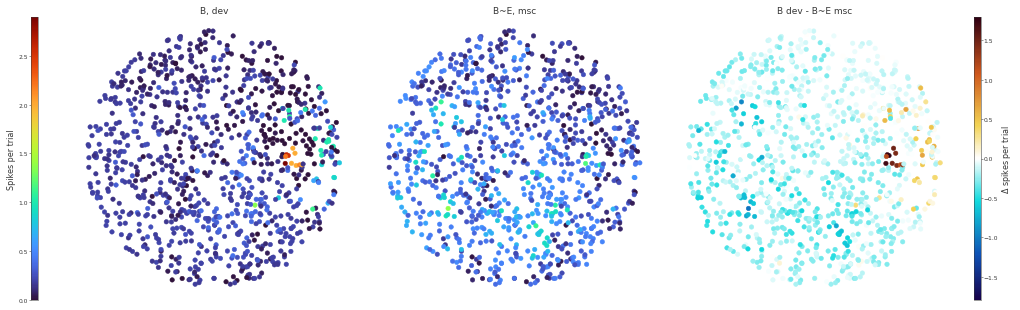

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs([half["XB_dev"], half["XnotA_msc"]]).max()
m = scatter_values(axs[0], c=half["XB_dev"], s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[0].set_title('B, dev')
m = scatter_values(axs[1], c=half["XnotA_msc"], s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[1].set_title('B~E, msc')
plt.colorbar(m, ax=axs, label='Spikes per trial', location='left', aspect=40, pad=0.02)

vmax = np.abs(half["dXnotA"]).max()
m = scatter_values(axs[2], c=half["dXnotA"], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('B dev - B~E msc')
plt.colorbar(m, ax=axs, label='$\\Delta$ spikes per trial', aspect=40, pad=0.02)

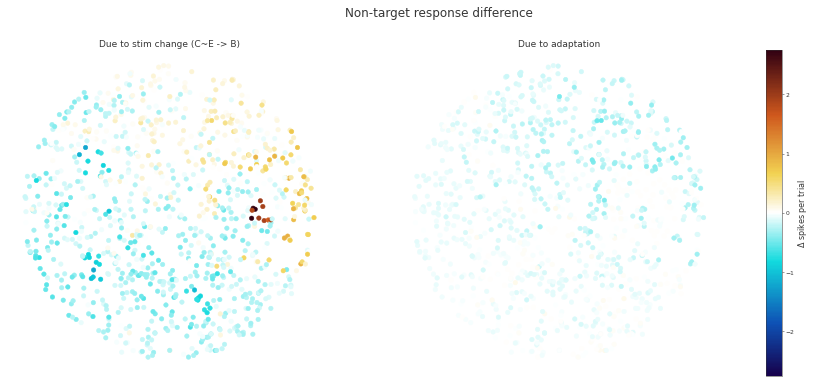

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
vmax = max(*[np.abs(val).max() for val in (half["dXB_adaptation"], half["dXB_stimchange"])])

fig.suptitle('Non-target response difference')
scatter_values(axs[0], c=half["dXB_stimchange"], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('Due to stim change (C~E -> B)')
m = scatter_values(axs[1], c=half["dXB_adaptation"], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('Due to adaptation')
plt.colorbar(m, ax=axs, label='$\\Delta$ spikes per trial')

dResponse: -0.18 spikes/trial
dV_TA: -0.12 mV
Regression slope: 1.2


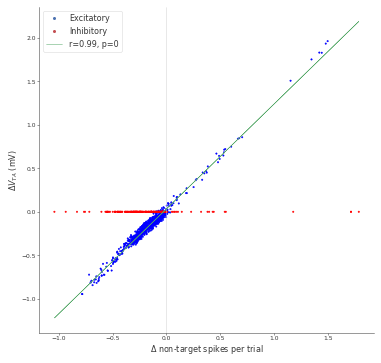

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(half["dXnotA"], half["dTA_A"], s=2, c=np.arange(cfg.params['N']) > cfg.params['N_exc'], cmap='bwr')
ax.axvline(0, color='lightgrey')
ax.set_xlabel('$\\Delta$ non-target spikes per trial')
ax.set_ylabel('$\\Delta V_{TA}$ (mV)')
ax.plot([], 'bo', ms=2, label='Excitatory')
ax.plot([], 'ro', ms=2, label='Inhibitory')
regression = stats.linregress(half["dXnotA"][:cfg.params['N_exc']], half["dTA_A"][:cfg.params['N_exc']])
ax.plot(half["dXnotA"], regression.intercept + regression.slope*half["dXnotA"], 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}')
ax.legend()
sns.despine()
print(f'dResponse: {np.median(half["dXnotA"]):.2g} spikes/trial')
print(f'dV_TA: {np.median(half["dTA_A"]):.2g} mV')
print(f'Regression slope: {regression.slope:.3g}')

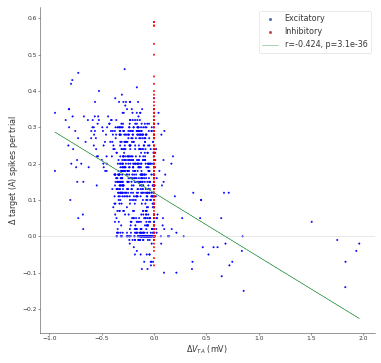

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(half["dTA_A"], half["dXA"], s=2, c=np.arange(cfg.params['N']) > cfg.params['N_exc'], cmap='bwr')
plt.axhline(0, color='lightgrey')
ax.set_xlabel('$\\Delta V_{TA}$ (mV)')
ax.set_ylabel('$\\Delta$ target (A) spikes per trial')
ax.plot([], 'bo', ms=2, label='Excitatory')
ax.plot([], 'ro', ms=2, label='Inhibitory')
regression = stats.linregress(half["dTA_A"][:cfg.params['N_exc']], half["dXA"][:cfg.params['N_exc']])
ax.plot(half["dTA_A"], regression.intercept + regression.slope*half["dTA_A"], 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}')
ax.legend()
sns.despine()

# STD+TA

In [16]:
isi, STD, TA, templ = 500, 1, 1, 'R'
res2 = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ), {'u': 'v'})
joint = {}

In [17]:
episodes = {cond: res2['pairs'][ipair][cond][stim] for cond in conds}
sequences = {cond: res2['sequences'][episode] for cond, episode in episodes.items()}
trials = {cond: seq == cfg.stimuli[stim] for cond, seq in sequences.items()}
trials.update({f'{cond}-nontarget': seq != cfg.stimuli[stim] for cond, seq in sequences.items()})
trials.update({f'{cond}-B': seq == cfg.stimuli[cfg.pairings[ipair][1-istim]] for cond, seq in sequences.items()})

In [18]:
joint["bspikes"] = {}
for cond in conds:
    joint["bspikes"][cond] = np.zeros((cfg.params['N'], len(sequences[cond]), res2['raw_dynamics']['v'].shape[-1]), bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res2['raw_spikes'][episodes[cond]][k] for k in ('pulsed_i', 'pulsed_t')])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        joint["bspikes"][cond][i, itrial, t] = True
    assert np.all(joint["bspikes"][cond].sum(2) == res2['raw_spikes'][episodes[cond]]['pulsed_nspikes'].T)

In [19]:
joint["TA_A_dev"] = res2['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev'], 0].mean(1)*volt/mV
joint["TA_A_msc"] = res2['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc'], 0].mean(1)*volt/mV
joint["dTA_A"] = joint["TA_A_dev"] - joint["TA_A_msc"]
joint["XA_dev"] = joint["bspikes"]['dev'][:, trials['dev']].sum(2).mean(1)
joint["XA_msc"] = joint["bspikes"]['msc'][:, trials['msc']].sum(2).mean(1)
joint["dXA"] = joint["XA_dev"] - joint["XA_msc"]
joint["TA_B_dev"] = res2['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev-B'], 0].mean(1)*volt/mV
joint["TA_B_msc"] = res2['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc-B'], 0].mean(1)*volt/mV
joint["dTA_B"] = joint["TA_B_dev"] - joint["TA_B_msc"]
joint["XB_dev"] = joint["XnotA_dev"] = joint["bspikes"]['dev'][:, trials['dev-B']].sum(2).mean(1)
joint["XB_msc"] = joint["bspikes"]['msc'][:, trials['msc-B']].sum(2).mean(1)
joint["XnotA_msc"] = joint["bspikes"]['msc'][:, ~trials['msc']].sum(2).mean(1)
joint["XnotAB_msc"] = joint["bspikes"]['msc'][:, ~(trials['msc']|trials['msc-B'])].sum(2).mean(1)
joint["dXnotA"] = joint["XB_dev"] - joint["XnotA_msc"]
joint["dXB_adaptation"] = joint["XB_dev"] - joint["XB_msc"]
joint["dXB_stimchange"] = joint["XB_msc"] - joint["XnotAB_msc"]

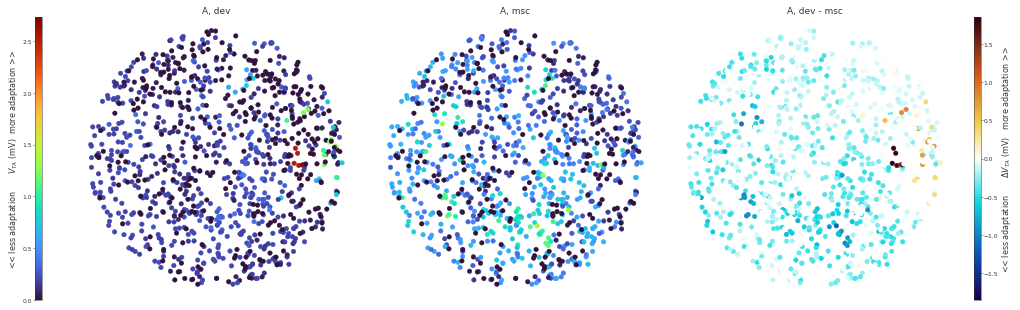

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs([joint["TA_A_dev"], joint["TA_A_msc"]]).max()
m = scatter_values(axs[0], c=joint["TA_A_dev"], s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[0].set_title('A, dev')
m = scatter_values(axs[1], c=joint["TA_A_msc"], s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[1].set_title('A, msc')
plt.colorbar(m, ax=axs, label='<< less adaptation\t $V_{TA}$ (mV) \tmore adaptation >>', location='left', aspect=40, pad=0.02)

vmax = np.abs(joint["dTA_A"]).max()
m = scatter_values(axs[2], c=joint["dTA_A"], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('A, dev - msc')
plt.colorbar(m, ax=axs, label='<< less adaptation\t $\\Delta V_{TA}$ (mV) \tmore adaptation >>', aspect=40, pad=0.02)

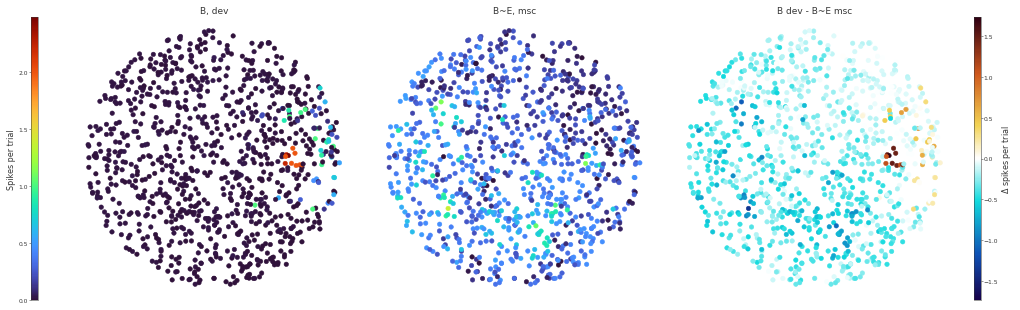

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs([joint["XB_dev"], joint["XnotA_msc"]]).max()
m = scatter_values(axs[0], c=joint["XB_dev"], s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[0].set_title('B, dev')
m = scatter_values(axs[1], c=joint["XnotA_msc"], s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[1].set_title('B~E, msc')
plt.colorbar(m, ax=axs, label='Spikes per trial', location='left', aspect=40, pad=0.02)

vmax = np.abs(joint["dXnotA"]).max()
m = scatter_values(axs[2], c=joint["dXnotA"], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('B dev - B~E msc')
plt.colorbar(m, ax=axs, label='$\\Delta$ spikes per trial', aspect=40, pad=0.02)

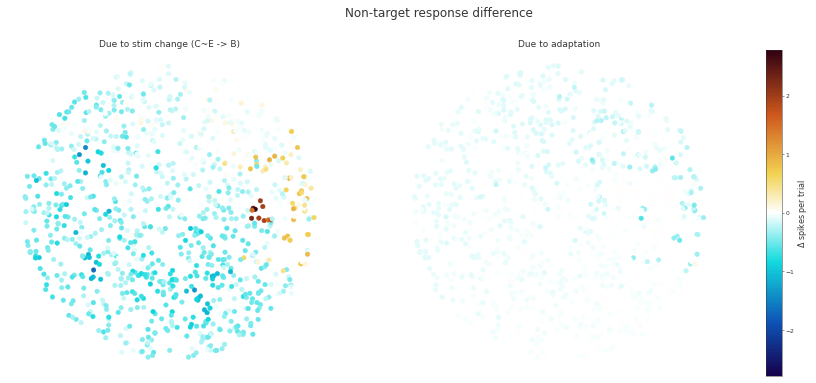

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
vmax = max(*[np.abs(val).max() for val in (joint["dXB_adaptation"], joint["dXB_stimchange"])])

fig.suptitle('Non-target response difference')
scatter_values(axs[0], c=joint["dXB_stimchange"], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('Due to stim change (C~E -> B)')
m = scatter_values(axs[1], c=joint["dXB_adaptation"], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('Due to adaptation')
plt.colorbar(m, ax=axs, label='$\\Delta$ spikes per trial')

dResponse: -0.28 spikes/trial
dV_TA: -0.18 mV
Regression slope: 1.11


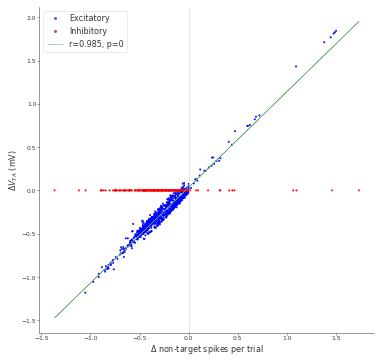

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(joint["dXnotA"], joint["dTA_A"], s=2, c=np.arange(cfg.params['N']) > cfg.params['N_exc'], cmap='bwr')
ax.axvline(0, color='lightgrey')
ax.set_xlabel('$\\Delta$ non-target spikes per trial')
ax.set_ylabel('$\\Delta V_{TA}$ (mV)')
ax.plot([], 'bo', ms=2, label='Excitatory')
ax.plot([], 'ro', ms=2, label='Inhibitory')
regression = stats.linregress(joint["dXnotA"][:cfg.params['N_exc']], joint["dTA_A"][:cfg.params['N_exc']])
ax.plot(joint["dXnotA"], regression.intercept + regression.slope*joint["dXnotA"], 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}')
ax.legend()
sns.despine()
print(f'dResponse: {np.median(joint["dXnotA"]):.2g} spikes/trial')
print(f'dV_TA: {np.median(joint["dTA_A"]):.2g} mV')
print(f'Regression slope: {regression.slope:.3g}')

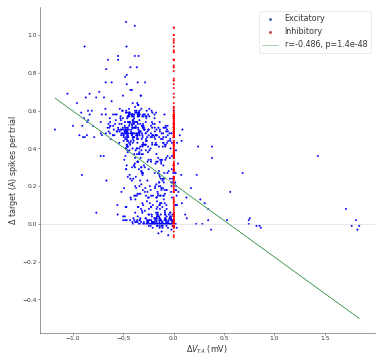

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(joint["dTA_A"], joint["dXA"], s=2, c=np.arange(cfg.params['N']) > cfg.params['N_exc'], cmap='bwr')
plt.axhline(0, color='lightgrey')
ax.set_xlabel('$\\Delta V_{TA}$ (mV)')
ax.set_ylabel('$\\Delta$ target (A) spikes per trial')
ax.plot([], 'bo', ms=2, label='Excitatory')
ax.plot([], 'ro', ms=2, label='Inhibitory')
regression = stats.linregress(joint["dTA_A"][:cfg.params['N_exc']], joint["dXA"][:cfg.params['N_exc']])
ax.plot(joint["dTA_A"], regression.intercept + regression.slope*joint["dTA_A"], 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}')
ax.legend()
sns.despine()

In [25]:
def spatial_contrast(axs_raw, cax_raw, ax_contrast, cax_contrast, dev, msc, diff, ms=1, raw_symmetric=False):
    vmax = np.abs([dev, msc]).max()
    vmin = -vmax if raw_symmetric else 0
    cmap_raw = pu.ccc_divergent if raw_symmetric else 'turbo'
    m = scatter_values(axs_raw[0], c=dev, s=ms, vmin=vmin, vmax=vmax, cmap=cmap_raw)
    m = scatter_values(axs_raw[1], c=msc, s=ms, vmin=vmin, vmax=vmax, cmap=cmap_raw)
    plt.colorbar(m, cax=cax_raw)
    cax_raw.yaxis.set_ticks_position('left')
    cax_raw.yaxis.set_label_position('left')

    if ax_contrast is None:
        return

    vmax = np.abs(diff).max()
    m = scatter_values(ax_contrast, c=diff, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
    plt.colorbar(m, cax=cax_contrast)

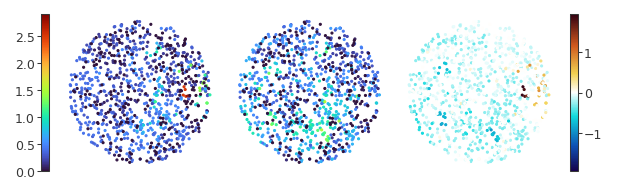

In [26]:
fig, axs = plt.subplots(1, 5, figsize=(4, 2), gridspec_kw={'width_ratios': (.1,2,2,2,.1)}, dpi=150, layout='compressed')
spatial_contrast(axs[1:3], axs[0], axs[3], axs[4], half['TA_A_dev'], half['TA_A_msc'], half['dTA_A'])

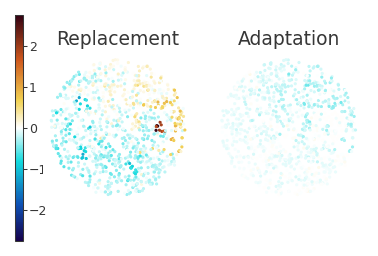

In [27]:
def panel_nontarget_causes_spatial(axs, cax, stimchange, adaptation, ms=1):
    vmax = max(*[np.abs(val).max() for val in (adaptation, stimchange)])
    scatter_values(axs[0], c=stimchange, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
    axs[0].set_title('Replacement')
    m = scatter_values(axs[1], c=adaptation, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
    axs[1].set_title('Adaptation')
    plt.colorbar(m, cax=cax)
    for ax in axs:
        ax.set_aspect('equal')

fig, axs = plt.subplots(1, 3, figsize=(3, 2), gridspec_kw={'width_ratios': (.1, 2, 2)}, dpi=150)
panel_nontarget_causes_spatial(axs[1:], axs[0], half["dXB_stimchange"], half["dXB_adaptation"])

In [28]:
statistics = dd.io.load('Fig6-stats.h5')

Replacement < 0: t = -0.255, p = 0.4
Adaptation < 0: t = -9.01, p = 2.02e-15
Adaptation < Replacement: t = -2.29, p = 0.0119


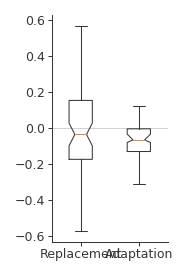

In [29]:
def panel_nontarget_causes_stats(ax, stimchange, adaptation):
    ax.axhline(0, color='lightgrey')
    ax.boxplot([change.mean(1) for change in (stimchange, adaptation)], notch=True, bootstrap=10000, labels=['Replacement', 'Adaptation'], widths=.4)
    # ax.set_ylabel('$\\Delta$ spikes per trial and neuron')
    sns.despine(ax=ax)
    
    test = stats.ttest_1samp(stimchange.mean(1), 0, alternative='less')
    print(f'Replacement < 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.ttest_1samp(adaptation.mean(1), 0, alternative='less')
    print(f'Adaptation < 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.ttest_rel(adaptation.mean(1), stimchange.mean(1), alternative='less')
    print(f'Adaptation < Replacement: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')
fig, ax = plt.subplots(figsize=(1,2), dpi=150)
panel_nontarget_causes_stats(ax, statistics['stimchange'][0][1], statistics['adaptation'][0][1])

notA spikes vs A TA (demonstrator): r = 0.99, p = 0


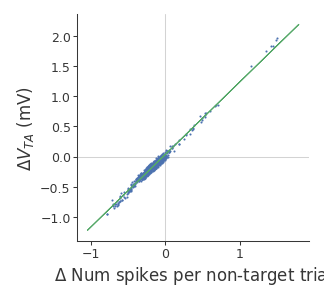

In [30]:
def panel_TAvSpikes(ax, data, ms=1, xlabel='Num spikes per non-target trial'):
    ax.axvline(0, color='lightgrey', zorder=0)
    ax.axhline(0, color='lightgrey', zorder=0)
    # ax.scatter(data["dXnotA"][cfg.params['N_exc']:], data["dTA_A"][cfg.params['N_exc']:], s=ms, marker='.', c='r', label='Inhibitory')
    ax.scatter(data["dXnotA"][:cfg.params['N_exc']], data["dTA_A"][:cfg.params['N_exc']], s=ms, marker='.', c='b', label='Excitatory')
    ax.set_xlabel(f'$\\Delta$ {xlabel}')
    ax.set_ylabel('$\\Delta V_{TA}$ (mV)')
    regression = stats.linregress(data["dXnotA"][:cfg.params['N_exc']], data["dTA_A"][:cfg.params['N_exc']])
    ax.plot(data["dXnotA"], regression.intercept + regression.slope*data["dXnotA"], 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}')
    # ax.legend()
    print(f'notA spikes vs A TA (demonstrator): r = {regression.rvalue:.3g}, p = {regression.pvalue:.3g}')
    sns.despine(ax=ax)
fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_TAvSpikes(ax, half)

notA spikes vs A TA (medians): r = 0.956, p = 5.98e-65


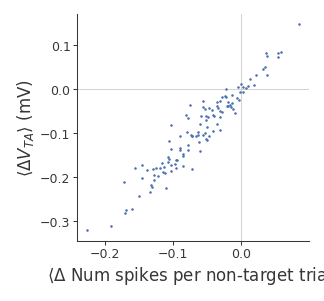

In [31]:
def panel_TAvSpikes_stats(ax, dXnotA, dTA_A, ms=2, xlabel='Num spikes per non-target trial'):
    ax.axvline(0, color='lightgrey', zorder=0)
    ax.axhline(0, color='lightgrey', zorder=0)
    x, y = [np.median(v[:, :cfg.params['N_exc']], 1) for v in (dXnotA, dTA_A)]
    ax.scatter(x, y, s=ms, marker='.')
    ax.set_xlabel(f'$\\langle \\Delta$ {xlabel}$\\rangle$')
    ax.set_ylabel('$\\langle \\Delta V_{TA} \\rangle$ (mV)')
    sns.despine(ax=ax)
    
    regression = stats.linregress(x, y)
    print(f'notA spikes vs A TA (medians): r = {regression.rvalue:.3g}, p = {regression.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_TAvSpikes_stats(ax, statistics['dXnotA'][0], statistics['dTA_A'][0])

In [32]:
def draw_stim_loc(ax):
    for s, AB in zip((stim, Bstim), 'AB'):
        x, y = [c[res['stimuli'][s]] for c in (Xstim, Ystim)]
        r = .2
        o = 1/np.sqrt(x**2+y**2)
        lpoints = np.asarray([1+r, .1+o])
        ax.add_patch(plt.Circle((x, y), r, fc='none', ec='magenta'))
        ax.plot(lpoints*x, lpoints*y, 'magenta', clip_on=False)
        ax.text(lpoints[-1]*x, lpoints[-1]*y, AB, ha='left' if x>=0 else 'right', va='bottom' if y>=0 else 'top')

No STD:
Replacement < 0: t = -0.255, p = 0.4
Adaptation < 0: t = -9.01, p = 2.02e-15
Adaptation < Replacement: t = -2.29, p = 0.0119
notA spikes vs A TA (demonstrator): r = 0.99, p = 0
notA spikes vs A TA (medians): r = 0.956, p = 5.98e-65

With STD:
Replacement < 0: t = -0.691, p = 0.246
Adaptation < 0: t = -10.2, p = 3.61e-18
Adaptation < Replacement: t = -2.31, p = 0.0114
notA spikes vs A TA (demonstrator): r = 0.985, p = 0
notA spikes vs A TA (medians): r = 0.966, p = 5.91e-71


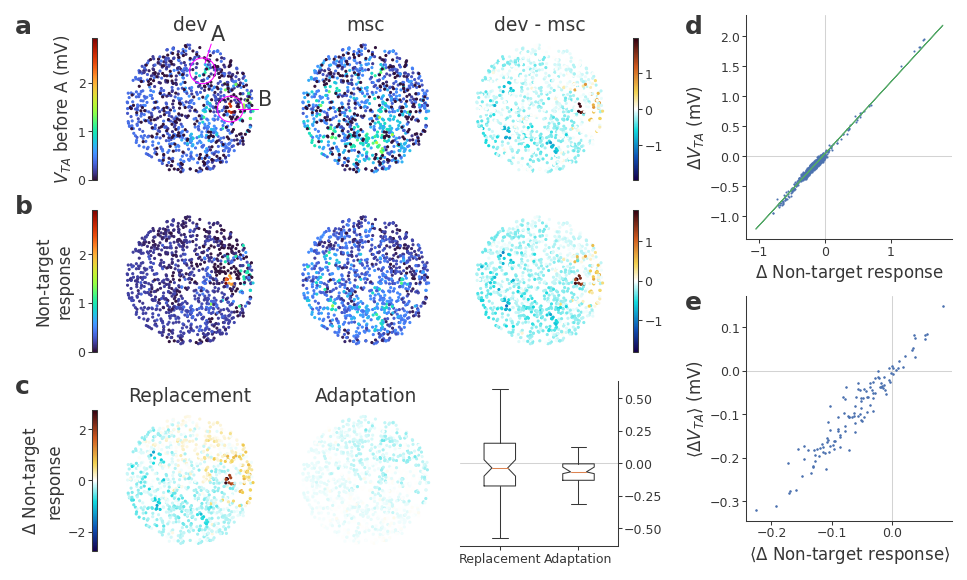

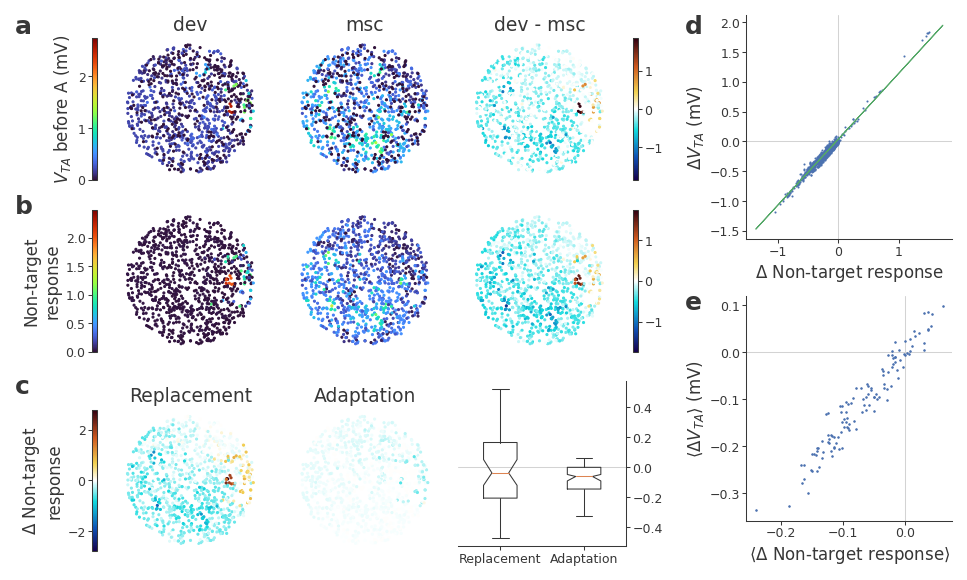

In [33]:
def make_figure_6(data, STD, TA, with_loc=True):
    fig = plt.figure(figsize=(6.29, 3.75), dpi=150, layout='compressed')
    gs_top = fig.add_gridspec(1, 2, width_ratios=(7,3))

    subfig_left = fig.add_subfigure(gs_top[0])
    wr = pu.fill_ratios(1, -1, -1, -1, 1)
    hr = pu.fill_ratios(-1, -1, 1, -1, 2)
    gs_left = subfig_left.add_gridspec(5, 5, width_ratios=wr, height_ratios=hr, hspace=.2)

    nspk_label = 'Non-target\nresponse'

    for row, (measure, title) in enumerate((('TA_A', '$V_{TA}$ before A (mV)'),
                                            ('XnotA', nspk_label))):
        cax_raw = subfig_left.add_subplot(gs_left[row, 0])
        axs_raw = [subfig_left.add_subplot(gs_left[row, i+1]) for i in range(2)]
        ax_diff = subfig_left.add_subplot(gs_left[row, 3])
        cax_diff = subfig_left.add_subplot(gs_left[row, 4])
        spatial_contrast(axs_raw, cax_raw, ax_diff, cax_diff, *[data[f'{measure}_{cond}'] for cond in ('dev', 'msc')], data[f'd{measure}'])
        if row == 0:
            axs_raw[0].set_title('dev')
            axs_raw[1].set_title('msc')
            ax_diff.set_title('dev - msc')
            if with_loc:
                draw_stim_loc(axs_raw[0])
        cax_raw.set_ylabel(title)
        # cax_diff.set_ylabel('$\\Delta$')

    cax = subfig_left.add_subplot(gs_left[3, 0])
    axs = [subfig_left.add_subplot(gs_left[3, i+1]) for i in range(2)]
    panel_nontarget_causes_spatial(axs, cax, data["dXB_stimchange"], data["dXB_adaptation"])
    cax.yaxis.set_ticks_position('left')
    cax.yaxis.set_label_position('left')
    cax.set_ylabel(f'$\\Delta$ {nspk_label}')

    subsubgs = gs_left[3:, 3:].subgridspec(1,1)
    ax = subfig_left.add_subplot(subsubgs[:])
    panel_nontarget_causes_stats(ax, statistics['stimchange'][STD][TA], statistics['adaptation'][STD][TA])
    sns.despine(ax=ax, left=True, right=False)

    subfig_right = fig.add_subfigure(gs_top[1])
    gs_summaries = subfig_right.add_gridspec(2,1)

    ax = subfig_right.add_subplot(gs_summaries[0])
    panel_TAvSpikes(ax, data, xlabel=nspk_label.replace('\n', ' '))

    ax = subfig_right.add_subplot(gs_summaries[1])
    panel_TAvSpikes_stats(ax, statistics['dXnotA'][STD], statistics['dTA_A'][STD], xlabel=nspk_label.replace('\n', ' '))

    for y, a in zip((.99, .67, .35), 'abc'):
        fig.text(0, y, a, **styling.label_kwargs, ha='left', va='top')
    for y, a in zip((.99, .5), 'de'):
        fig.text(.71, y, a, **styling.label_kwargs, ha='left', va='top')

print('No STD:')
make_figure_6(half, 0, 1)
plt.savefig('paper-1/fig5.pdf')

print('\nWith STD:')
make_figure_6(joint, 1, 1, with_loc=False)
plt.savefig('paper-1/fig5-withSTD.pdf')

# Compare

In [34]:
diff = {
    'TA_A': [joint[k] - half[k] for k in ('TA_A_dev', 'TA_A_msc', 'dTA_A')],
    'XnotA': [joint[k] - half[k] for k in ('XB_dev', 'XnotA_msc', 'dXnotA')],
    'XA': [joint[k] - half[k] for k in ('XA_dev', 'XA_msc', 'dXA')]
}

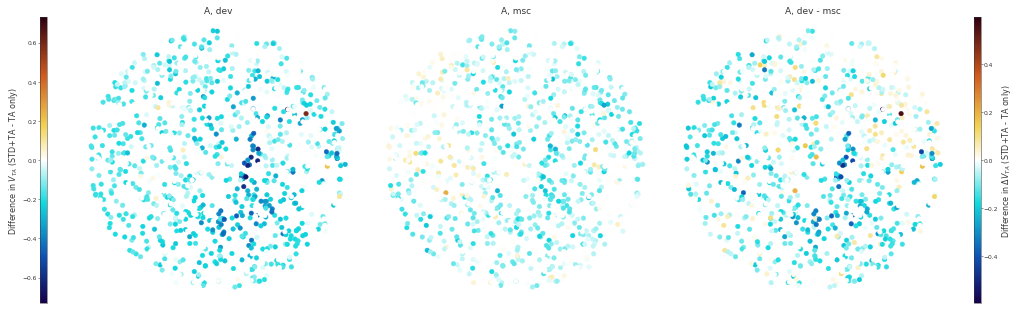

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs(diff['TA_A'][:2]).max()
m = scatter_values(axs[0], c=diff['TA_A'][0], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('A, dev')
m = scatter_values(axs[1], c=diff['TA_A'][1], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('A, msc')
plt.colorbar(m, ax=axs, label='Difference in $V_{TA}$ (STD+TA - TA only)', location='left', aspect=40, pad=0.02)

vmax = np.abs(diff['TA_A'][2]).max()
m = scatter_values(axs[2], c=diff['TA_A'][2], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('A, dev - msc')
plt.colorbar(m, ax=axs, label='Difference in $\\Delta V_{TA}$ (STD+TA - TA only)', aspect=40, pad=0.02)

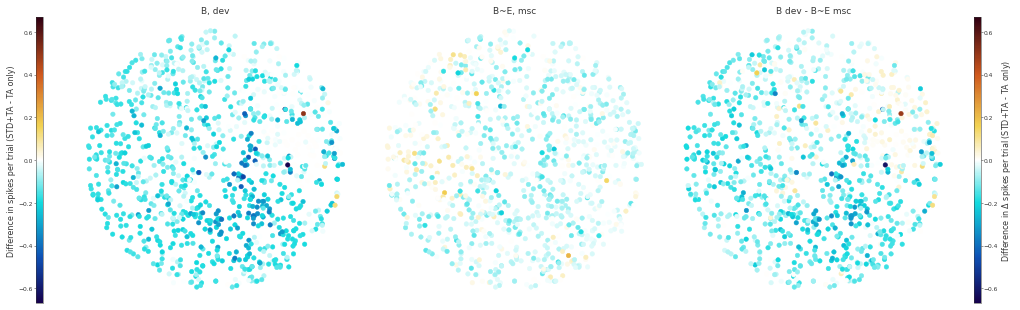

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs(diff['XnotA']).max()
m = scatter_values(axs[0], c=diff['XnotA'][0], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('B, dev')
m = scatter_values(axs[1], c=diff['XnotA'][1], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('B~E, msc')
plt.colorbar(m, ax=axs, label='Difference in spikes per trial (STD+TA - TA only)', location='left', aspect=40, pad=0.02)

vmax = np.abs(diff['XnotA']).max()
m = scatter_values(axs[2], c=diff['XnotA'][2], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('B dev - B~E msc')
plt.colorbar(m, ax=axs, label='Difference in $\\Delta$ spikes per trial (STD+TA - TA only)', aspect=40, pad=0.02)

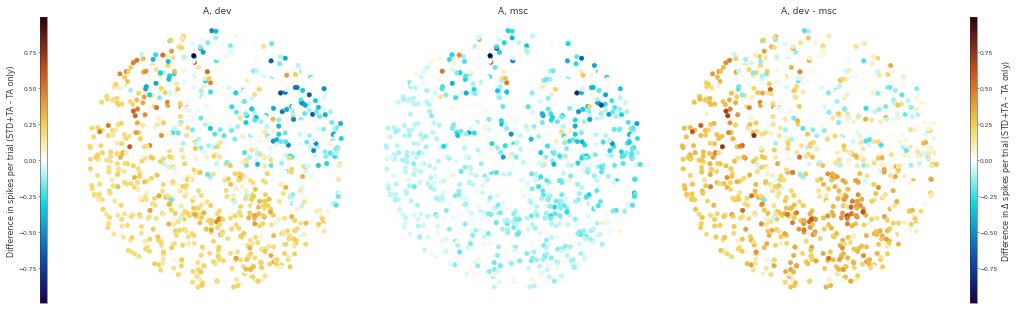

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs(diff['XA']).max()
m = scatter_values(axs[0], c=diff['XA'][0], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('A, dev')
m = scatter_values(axs[1], c=diff['XA'][1], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('A, msc')
plt.colorbar(m, ax=axs, label='Difference in spikes per trial (STD+TA - TA only)', location='left', aspect=40, pad=0.02)

vmax = np.abs(diff['XA']).max()
m = scatter_values(axs[2], c=diff['XA'][2], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('A, dev - msc')
plt.colorbar(m, ax=axs, label='Difference in $\\Delta$ spikes per trial (STD+TA - TA only)', aspect=40, pad=0.02)

In [38]:
nspikes = dd.io.load('Fig5n-stats.h5')
TAdata = dd.io.load('Fig8-synergy.h5', '/TA')
Ddata = dd.io.load('Fig8-synergy.h5', '/D')

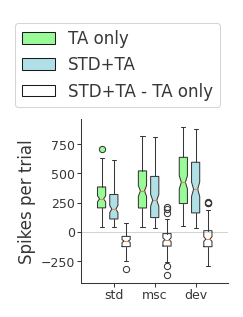

In [48]:
color_half, color_full = 'palegreen', 'powderblue'
pos = np.arange(3)
stats_pos = (pos, pos+.3, pos+.6)
stats_width = .2
def panel_stats_spikes(ax, nspikes):
    X_taonly = [nspikes[0][1][cond] for cond in conds]
    X_full = [nspikes[1][1][cond] for cond in conds]
    X_diff = [f-o for o, f in zip(X_taonly, X_full)]

    ax.boxplot(X_taonly, positions=stats_pos[0], notch=True, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_half}, flierprops={'markerfacecolor': color_half})

    ax.boxplot(X_full, positions=stats_pos[1], notch=True, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_full}, flierprops={'markerfacecolor': color_full})
    
    ax.boxplot(X_diff, positions=stats_pos[2], notch=True, widths=stats_width)
    ax.axhline(0, color='lightgrey', zorder=0)

    ax.set_xticks(np.mean(stats_pos, 0), conds)
    ax.set_ylabel('Spikes per trial')
    sns.despine(ax=ax)

def legend_stats(ax, **kwargs):
    ax.fill_between([], [], [], label='TA only', color=color_half, ec='k')
    ax.fill_between([], [], [], label='STD+TA', color=color_full, ec='k')
    ax.fill_between([], [], [], label='STD+TA - TA only', color='w', ec='k')
    ax.legend(**kwargs)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])

fig = plt.figure(figsize=(1.5,2), layout='constrained', dpi=150)
gs = fig.add_gridspec(2,1, height_ratios=(1,5))
legend_stats(fig.add_subplot(gs[0]))
panel_stats_spikes(fig.add_subplot(gs[1]), nspikes)

dRespones std<msc: t = -1.9, p = 0.0297
dRespones msc<dev: t = -2.99, p = 0.00168


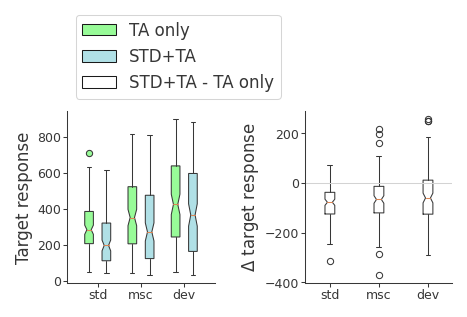

In [73]:
def panel_stats_spikes_raw(ax, nspikes):
    X_taonly = [nspikes[0][1][cond] for cond in conds]
    X_full = [nspikes[1][1][cond] for cond in conds]
    pos1 = np.arange(3)
    pos2 = np.arange(3)+.4

    ax.boxplot(X_taonly, positions=pos1, notch=True, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_half}, flierprops={'markerfacecolor': color_half})
    ax.boxplot(X_full, positions=pos2, notch=True, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_full}, flierprops={'markerfacecolor': color_full})

    ax.set_xticks((pos1+pos2)/2, conds)
    ax.set_ylabel('Target response')
    sns.despine(ax=ax)

def panel_stats_spikes_diff(ax, nspikes):
    X_taonly = [nspikes[0][1][cond] for cond in conds]
    X_full = [nspikes[1][1][cond] for cond in conds]
    X_diff = [f-o for o, f in zip(X_taonly, X_full)]

    ax.boxplot(X_diff, notch=True, widths=stats_width)
    ax.axhline(0, color='lightgrey')
    ax.set_ylabel('$\\Delta$ target response')
    ax.set_xticks(range(1,4), conds)
    sns.despine(ax=ax)

    test = stats.ttest_rel(X_diff[0], X_diff[1], alternative='less')
    print(f'dRespones std<msc: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.ttest_rel(X_diff[1], X_diff[2], alternative='less')
    print(f'dRespones msc<dev: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')

fig = plt.figure(figsize=(3,2), layout='constrained', dpi=150)
gs = fig.add_gridspec(2,2, height_ratios=(1,5))
legend_stats(fig.add_subplot(gs[0,:]), loc='center left')
panel_stats_spikes_raw(fig.add_subplot(gs[1,0]), nspikes)
panel_stats_spikes_diff(fig.add_subplot(gs[1,1]), nspikes)

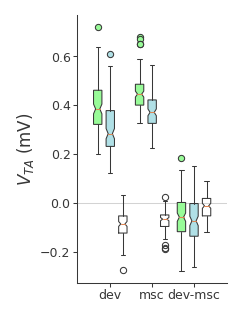

In [41]:
def panel_stats_TA(ax, TAdata):
    Vta_taonly = {cond: np.asarray([TAdata[0][k]['A'][cond] for k in range(len(TAdata[0]))]) for cond in ('dev', 'msc')}
    Vta_full = {cond: np.asarray([TAdata[1][k]['A'][cond] for k in range(len(TAdata[1]))]) for cond in ('dev', 'msc')}
    Vta_diff = {cond: Vta_full[cond] - Vta_taonly[cond] for cond in ('dev', 'msc')}
    Vta_taonly['dev-msc'] = Vta_taonly['dev'] - Vta_taonly['msc']
    Vta_full['dev-msc'] = Vta_full['dev'] - Vta_full['msc']
    Vta_diff['dev-msc'] = Vta_diff['dev'] - Vta_diff['msc']

    ax.boxplot([v.mean(1) for v in Vta_taonly.values()], positions=stats_pos[0], notch=True, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_half}, flierprops={'markerfacecolor': color_half})

    ax.boxplot([v.mean(1) for v in Vta_full.values()], positions=stats_pos[1], notch=True, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_full}, flierprops={'markerfacecolor': color_full})
    
    ax.boxplot([v.mean(1) for v in Vta_diff.values()], positions=stats_pos[2], notch=True, widths=stats_width)
    ax.axhline(0, color='lightgrey', zorder=0)

    ax.set_xticks(np.mean(stats_pos, 0), Vta_full.keys())
    ax.set_ylabel('$V_{TA}$ (mV)')
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(1.5,2), layout='constrained', dpi=150)
panel_stats_TA(ax, TAdata)

dTA dev<msc: t = -3.49, p = 0.000342


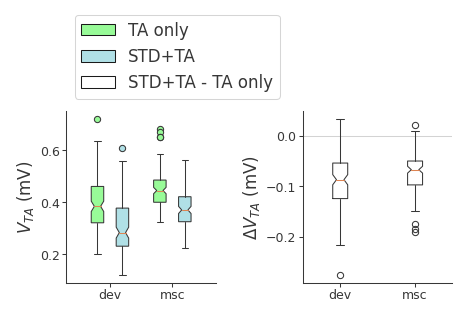

In [74]:
def panel_stats_TA_raw(ax, TAdata):
    Vta_taonly = {cond: np.asarray([TAdata[0][k]['A'][cond] for k in range(len(TAdata[0]))]) for cond in ('dev', 'msc')}
    Vta_full = {cond: np.asarray([TAdata[1][k]['A'][cond] for k in range(len(TAdata[1]))]) for cond in ('dev', 'msc')}
    # Vta_taonly['dev-msc'] = Vta_taonly['dev'] - Vta_taonly['msc']
    # Vta_full['dev-msc'] = Vta_full['dev'] - Vta_full['msc']
    pos1 = np.arange(2)
    pos2 = np.arange(2)+.4

    ax.boxplot([v.mean(1) for v in Vta_taonly.values()], positions=pos1, notch=True, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_half}, flierprops={'markerfacecolor': color_half})

    ax.boxplot([v.mean(1) for v in Vta_full.values()], positions=pos2, notch=True, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_full}, flierprops={'markerfacecolor': color_full})

    ax.set_xticks((pos1+pos2)/2, Vta_full.keys())
    ax.set_ylabel('$V_{TA}$ (mV)')
    sns.despine(ax=ax)

def panel_stats_TA_diff(ax, TAdata):
    Vta_taonly = {cond: np.asarray([TAdata[0][k]['A'][cond] for k in range(len(TAdata[0]))]) for cond in ('dev', 'msc')}
    Vta_full = {cond: np.asarray([TAdata[1][k]['A'][cond] for k in range(len(TAdata[1]))]) for cond in ('dev', 'msc')}
    Vta_diff = {cond: Vta_full[cond] - Vta_taonly[cond] for cond in ('dev', 'msc')}
    # Vta_diff['dev-msc'] = Vta_diff['dev'] - Vta_diff['msc']
    
    ax.boxplot([v.mean(1) for v in Vta_diff.values()], notch=True, widths=stats_width, labels=Vta_diff.keys())
    ax.axhline(0, color='lightgrey', zorder=0)

    ax.set_ylabel('$\\Delta V_{TA}$ (mV)')
    sns.despine(ax=ax)

    test = stats.ttest_rel(Vta_diff['dev'].mean(1), Vta_diff['msc'].mean(1), alternative='less')
    print(f'dTA dev<msc: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')

fig = plt.figure(figsize=(3,2), layout='constrained', dpi=150)
gs = fig.add_gridspec(2,2, height_ratios=(1,5))
legend_stats(fig.add_subplot(gs[0,:]), loc='center left')
panel_stats_TA_raw(fig.add_subplot(gs[1,0]), TAdata)
panel_stats_TA_diff(fig.add_subplot(gs[1,1]), TAdata)

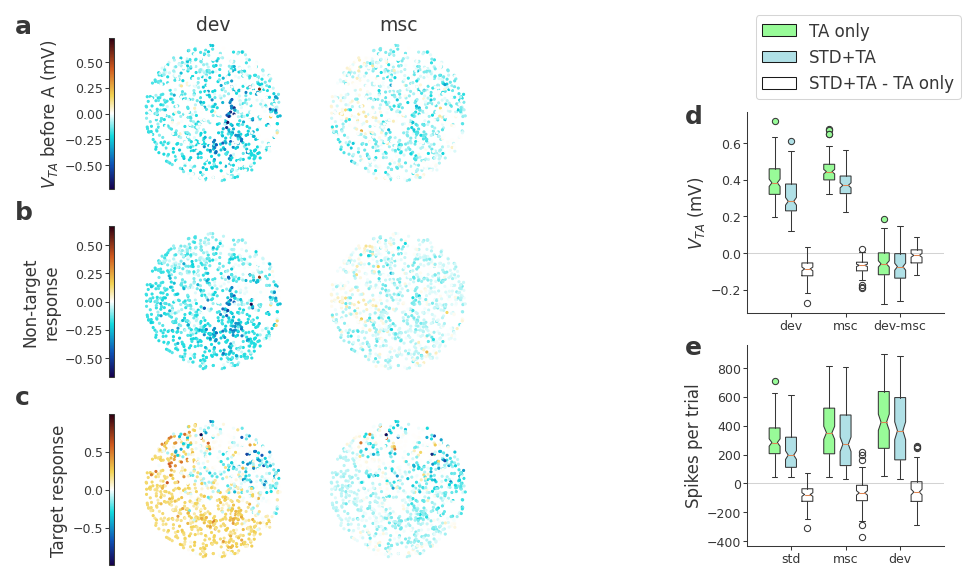

In [45]:
fig = plt.figure(figsize=(6.29, 3.75), dpi=150, layout='compressed')
gs_top = fig.add_gridspec(1, 2, width_ratios=(7,3))

subfig_left = fig.add_subfigure(gs_top[0])
wr = pu.fill_ratios(1, -1, -1, -1, 1)
gs_left = subfig_left.add_gridspec(3, 5, width_ratios=wr, hspace=.2)

for row, (measure, title) in enumerate((('TA_A', '$V_{TA}$ before A (mV)'),
                                        ('XnotA', 'Non-target\nresponse'),
                                        ('XA', 'Target response'))):
    cax_raw = subfig_left.add_subplot(gs_left[row, 0])
    axs_raw = [subfig_left.add_subplot(gs_left[row, i+1]) for i in range(2)]
    ax_diff = subfig_left.add_subplot(gs_left[row, 3])
    cax_diff = subfig_left.add_subplot(gs_left[row, 4])
    spatial_contrast(axs_raw, cax_raw, ax_diff, cax_diff, *diff[measure], raw_symmetric=True)
    if row == 0:
        axs_raw[0].set_title('dev')
        axs_raw[1].set_title('msc')
        ax_diff.set_title('dev - msc')
    cax_raw.set_ylabel(title)
    # cax_diff.set_ylabel('$\\Delta$')

subfig_right = fig.add_subfigure(gs_top[1])
gs_summaries = subfig_right.add_gridspec(3, 1, height_ratios=(1,5,5))

legend_stats(subfig_right.add_subplot(gs_summaries[0]), loc='center left')
panel_stats_TA(subfig_right.add_subplot(gs_summaries[1]), TAdata)
panel_stats_spikes(subfig_right.add_subplot(gs_summaries[2]), nspikes)

for y, a in zip((.99, .66, .33), 'abc'):
    fig.text(0, y, a, **styling.label_kwargs, ha='left', va='top')
for y, a in zip((.83, .42), 'de'):
    fig.text(.71, y, a, **styling.label_kwargs, ha='left', va='top')

plt.savefig('paper-1/fig6.pdf')

dTA dev<msc: t = -3.49, p = 0.000342
dRespones std<msc: t = -1.9, p = 0.0297
dRespones msc<dev: t = -2.99, p = 0.00168


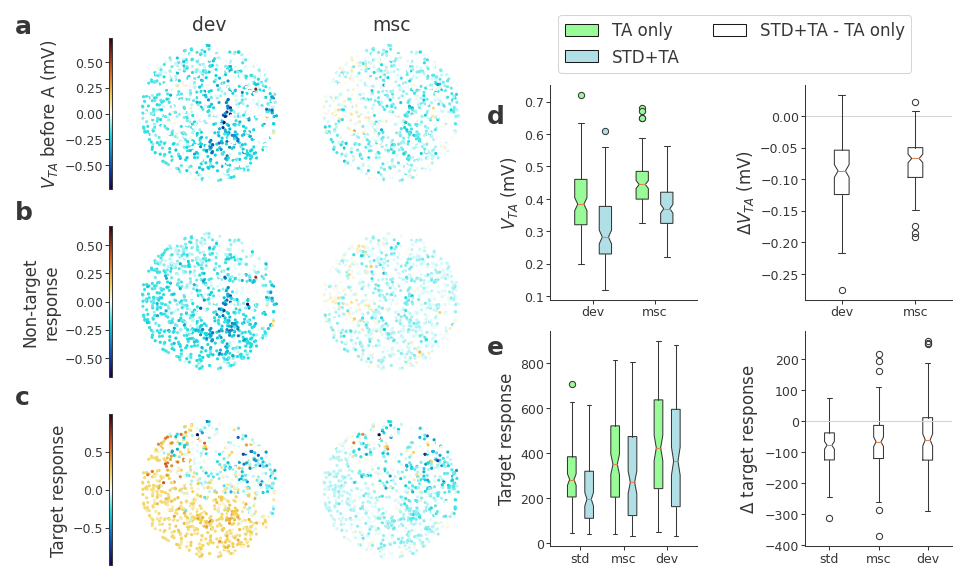

In [76]:
fig = plt.figure(figsize=(6.29, 3.75), dpi=150, layout='compressed')
gs_top = fig.add_gridspec(1, 2, width_ratios=(3,3))

subfig_left = fig.add_subfigure(gs_top[0])
wr = pu.fill_ratios(1, -1, -1)
gs_left = subfig_left.add_gridspec(3, 3, width_ratios=wr, hspace=.2)

for row, (measure, title) in enumerate((('TA_A', '$V_{TA}$ before A (mV)'),
                                        ('XnotA', 'Non-target\nresponse'),
                                        ('XA', 'Target response'))):
    cax_raw = subfig_left.add_subplot(gs_left[row, 0])
    axs_raw = [subfig_left.add_subplot(gs_left[row, i+1]) for i in range(2)]
    spatial_contrast(axs_raw, cax_raw, None, None, *diff[measure], raw_symmetric=True)
    if row == 0:
        axs_raw[0].set_title('dev')
        axs_raw[1].set_title('msc')
    cax_raw.set_ylabel(title)

subfig_right = fig.add_subfigure(gs_top[1])
gs_summaries = subfig_right.add_gridspec(3, 2, height_ratios=(1,5,5))

legend_stats(subfig_right.add_subplot(gs_summaries[0, :]), loc='center left', ncol=2)
panel_stats_TA_raw(subfig_right.add_subplot(gs_summaries[1,0]), TAdata)
panel_stats_TA_diff(subfig_right.add_subplot(gs_summaries[1,1]), TAdata)
panel_stats_spikes_raw(subfig_right.add_subplot(gs_summaries[2,0]), nspikes)
panel_stats_spikes_diff(subfig_right.add_subplot(gs_summaries[2,1]), nspikes)

for y, a in zip((.99, .66, .33), 'abc'):
    fig.text(0, y, a, **styling.label_kwargs, ha='left', va='top')
for y, a in zip((.83, .42), 'de'):
    fig.text(.5, y, a, **styling.label_kwargs, ha='left', va='top')

plt.savefig('paper-1/fig6.pdf')